## Data Collection & Labeling


### 1. Loading and Inspecting the Dataset

In [5]:
import pandas as pd

# Loading the dataset
df = pd.read_csv("Amazon-Deutsch-Dataset.csv")

In [6]:
# Checking dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3413 entries, 0 to 3412
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             3413 non-null   int64  
 1   web-scraper-order      3413 non-null   object 
 2   web-scraper-start-url  3413 non-null   object 
 3   author                 3409 non-null   object 
 4   title                  3409 non-null   object 
 5   date                   3409 non-null   object 
 6   content                3409 non-null   object 
 7   rating                 3409 non-null   object 
 8   next                   3299 non-null   object 
 9   next-href              3303 non-null   object 
 10  Unnamed: 9             0 non-null      float64
dtypes: float64(1), int64(1), object(9)
memory usage: 293.4+ KB


In [7]:
# Describing numerical columns
df.describe()

,Unnamed: 0,Unnamed: 9
count,3413.000000,0.0
mean,1706.000000,NaN
std,985.392561,NaN
min,0.000000,NaN
25%,853.000000,NaN
50%,1706.000000,NaN
75%,2559.000000,NaN
max,3412.000000,NaN


In [8]:
# Checking for missing values
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 Unnamed: 0                  0
web-scraper-order           0
web-scraper-start-url       0
author                      4
title                       4
date                        4
content                     4
rating                      4
next                      114
next-href                 110
Unnamed: 9               3413
dtype: int64


In [9]:
# Previewing first few rows
df.head(2)

,Unnamed: 0,web-scraper-order,web-scraper-start-url,author,title,date,content,rating,next,next-href,Unnamed: 9
0,0,1582056286-2631,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,MHS,Das Beste iPhone aller Zeiten,5. Januar 2020,Ich bin sehr zufrieden mit dem iPhone 11. Der ...,"5,0 von 5 Sternen",Weiter→,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,NaN
1,1,1582056184-2351,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,Amazon Customer,besser als beim hersteller,21. September 2019,"gestern bestellt, heute geliefert. besser geht...","5,0 von 5 Sternen",NaN,NaN,NaN


### 2. Cleaning Column Names and Extract Numeric Ratings

In [10]:
# Renaming columns for clarity
df = df.rename(columns={
    'content': 'review_text',
    'rating': 'rating_raw'
})

# Extracting numeric rating from German format (e.g., "4,0 von 5 Sternen")
df['rating'] = df['rating_raw'].str.extract(r'(\d+,\d+)')
df['rating'] = df['rating'].str.replace(',', '.').astype(float)

# Previewing cleaned rating column
df[['rating_raw', 'rating']].head()


,rating_raw,rating
0,"5,0 von 5 Sternen",5.0
1,"5,0 von 5 Sternen",5.0
2,"4,0 von 5 Sternen",4.0
3,"5,0 von 5 Sternen",5.0
4,"5,0 von 5 Sternen",5.0


### 3. Computing Review Length

In [11]:
# Calculating number of words in each review
df['review_length'] = df['review_text'].astype(str).apply(lambda x: len(x.split()))

# Quick preview
df[['review_text', 'review_length']].head()

,review_text,review_length
0,Ich bin sehr zufrieden mit dem iPhone 11. Der ...,28
1,"gestern bestellt, heute geliefert. besser geht...",13
2,"Ich mach es mal kurz:\nGut: Optik, Verarbeitun...",16
3,Amazon hat wieder super-schnell geliefert. Dan...,71
4,"Viel früher angekommen als angegeben, tolles H...",26


### 4. Apply Heuristic Labeling Rules

In [12]:
# Defining rule-based labeling function
def label_review(row):
    if row['rating'] < 4.0:
        return 0  # genuine
    elif row['rating'] == 5.0 and row['review_length'] < 30:
        return 1  # possibly fake
    elif any(word in str(row['review_text']).lower() for word in ['beste', 'unglaublich', 'perfekt']):
        return 1  # possibly fake
    else:
        return 0  # default genuine

# Applying labeling
df['label'] = df.apply(label_review, axis=1)

# Showing label distribution
df['label'].value_counts()


label
0    2716
1     697
Name: count, dtype: int64

### 5. Finalizing Cleaned DataFrame

In [13]:
# Keeping only relevant columns
df_final = df[['author', 'title', 'review_text', 'rating', 'review_length', 'label']]

# Previewing final cleaned dataset
df_final.head()

,author,title,review_text,rating,review_length,label
0,MHS,Das Beste iPhone aller Zeiten,Ich bin sehr zufrieden mit dem iPhone 11. Der ...,5.0,28,1
1,Amazon Customer,besser als beim hersteller,"gestern bestellt, heute geliefert. besser geht...",5.0,13,1
2,Joko Müller,Gutes Handy mit kleinen Schwächen,"Ich mach es mal kurz:\nGut: Optik, Verarbeitun...",4.0,16,0
3,Davorko,Ein sehr edles Stück dieses IPHONE 11,Amazon hat wieder super-schnell geliefert. Dan...,5.0,71,1
4,Chiara Natalia Sozzi,Super,"Viel früher angekommen als angegeben, tolles H...",5.0,26,1


### Converting to a csv file

In [14]:
df_final.to_csv('cleaned_data.csv', index=False)


## Text Preprocessing (German)

###  Preprocessing Code

In [15]:
import spacy
import re
from spacy.lang.de.stop_words import STOP_WORDS

# Loading German language model
nlp = spacy.load("de_core_news_sm")

# Function for text cleaning and lemmatization
def preprocess_text(text):
    # Converting to lowercase
    text = text.lower()
    # Removing special characters and numbers
    text = re.sub(r'[^a-zA-ZäöüßÄÖÜ ]', '', text)
    # Process using spaCy
    doc = nlp(text)
    # Lemmatize and remove stopwords
    tokens = [token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS and token.is_alpha]
    return " ".join(tokens)

# Applying to a sample (to test speed first)
df_final['cleaned_text'] = df_final['review_text'].astype(str).apply(preprocess_text)

# Previewing cleaned output
df_final[['review_text', 'cleaned_text']].head()


C:\Users\darsh\AppData\Local\Temp\ipykernel_5128\3079093710.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['cleaned_text'] = df_final['review_text'].astype(str).apply(preprocess_text)


,review_text,cleaned_text
0,Ich bin sehr zufrieden mit dem iPhone 11. Der ...,zufrieden Iphone Wechsel Iphone s riesig quant...
1,"gestern bestellt, heute geliefert. besser geht...",gestern bestellen liefern gehts rot sehen einf...
2,"Ich mach es mal kurz:\nGut: Optik, Verarbeitun...",mal kurzgut Optik Verarbeitung betriebssystem ...
3,Amazon hat wieder super-schnell geliefert. Dan...,Amazon superschnell liefern danken Iphone sowe...
4,"Viel früher angekommen als angegeben, tolles H...",früh ankommen angeben toll Handy xr Muss sagen...


## TF-IDF Vectorization (German)

### Import & Apply TF-IDF Vectorizer


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Using top 5000 features to avoid sparsity
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Applying to cleaned text
X_tfidf = tfidf_vectorizer.fit_transform(df_final['cleaned_text'])

# Showing shape and type
X_tfidf.shape

(3413, 5000)

### Preparing Feature Matrix and Labels

In [17]:
# Defining features (X) and labels (y)
X = X_tfidf
y = df_final['label']

In [18]:
# Viewing top 10 TF-IDF features
feature_names = tfidf_vectorizer.get_feature_names_out()
top_features = feature_names[:10]
print("Top features:", top_features)

Top features: ['aa' 'aaa' 'aan' 'abbekommen' 'abbilden' 'abbrechen' 'abbricht'
 'abdecken' 'abdeckung' 'abdunkel']


## Model Building

### Spliting Data for Training & Testing

In [19]:
from sklearn.model_selection import train_test_split

# Spliting data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2730, 5000), (683, 5000), (2730,), (683,))

### Training Logistic Regression Model

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and train
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predicting and evaluate
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_logreg))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       544
           1       0.77      0.31      0.44       139

    accuracy                           0.84       683
   macro avg       0.81      0.64      0.67       683
weighted avg       0.83      0.84      0.81       683



### ROC-AUC Evaluation

ROC AUC Score: 0.8992


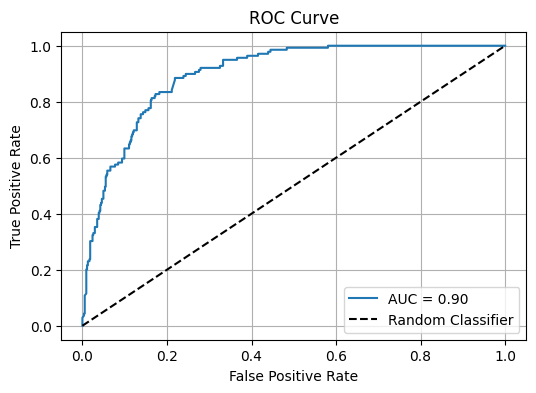

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predicting probabilities
y_proba = logreg.predict_proba(X_test)[:, 1]

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", round(roc_score, 4))

# Ploting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


### Training Random Forest Model (for comparison)

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predicting and evaluate
y_pred_rf = rf.predict(X_test)
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       544
           1       0.68      0.54      0.60       139

    accuracy                           0.86       683
   macro avg       0.79      0.74      0.76       683
weighted avg       0.85      0.86      0.85       683



### SHAP Analysis on Random Forest

c:\Users\darsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


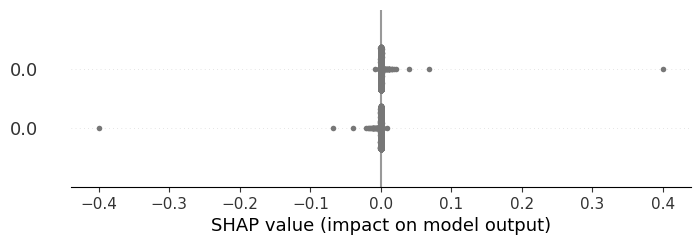

In [23]:
import shap

# Converting sparse TF-IDF test data to dense format
X_sample = X_test[:10].toarray()

# Initializing SHAP explainer for tree models
explainer = shap.Explainer(rf, X_sample)

# Calculating SHAP values for class 1 (fake)
shap_values = explainer(X_sample)

# Ploting the feature importance
shap.plots.beeswarm(shap_values[1])



c:\Users\darsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


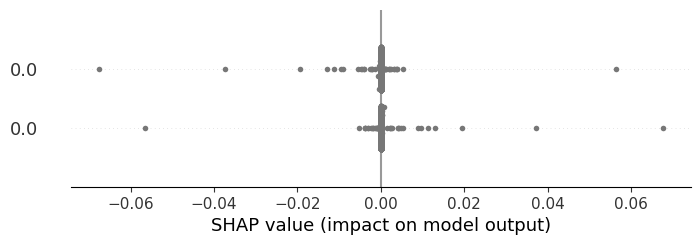

In [24]:
shap.plots.beeswarm(shap_values[0])

<class 'shap._explanation.Explanation'>
(100, 1000, 2)


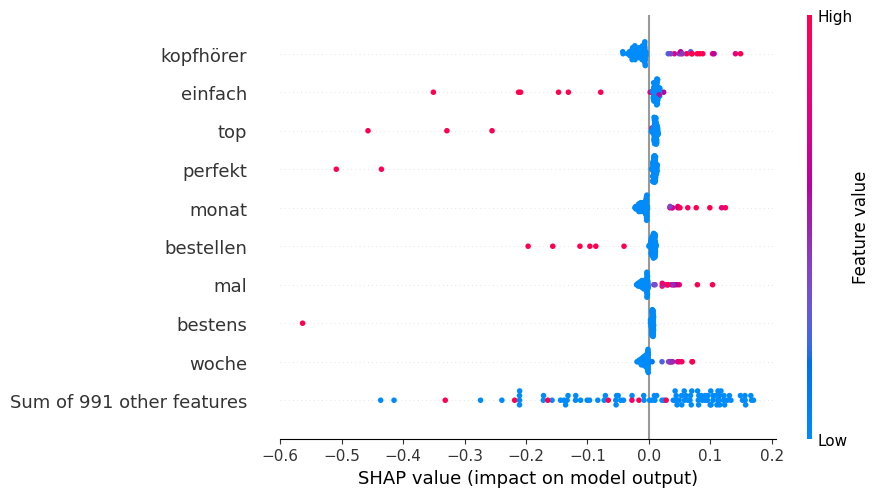

In [25]:
# 1. Defining text and target
corpus = df_final['cleaned_text'].values
y = df_final['label'].values

# 2. Vectorizing the cleaned text
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(corpus)

# 3. Train/test spliting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Training the Random Forest model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 5. Preparing for SHAP - convert to dense format with feature names
try:
    feature_names = vectorizer.get_feature_names_out()
except:
    feature_names = vectorizer.get_feature_names()

import pandas as pd
X_dense = pd.DataFrame(X_test.toarray(), columns=feature_names)
X_sample = X_dense.sample(100, random_state=42)

# 6. SHAP Explanation
import shap
explainer = shap.Explainer(rf, X_sample)
shap_values = explainer(X_sample)

# 7. Plot SHAP beeswarm chart
print(type(shap_values))
print(shap_values.shape)
shap.plots.beeswarm(shap_values[..., 0])  # For class 0

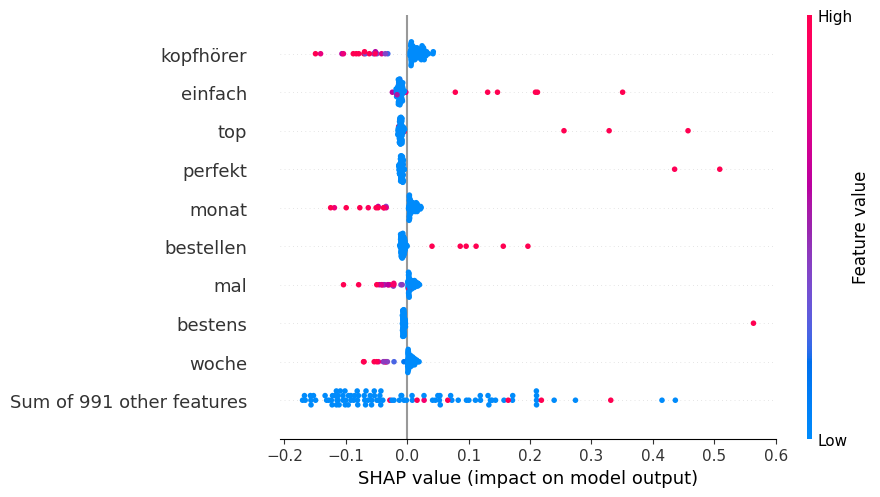

In [26]:
shap.plots.beeswarm(shap_values[..., 1])  # For class 1